In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, lasso_path, enet_path

sns.set_theme(style="darkgrid")

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
batch_path = lambda n: os.path.join("data",f"batch{n}.pkl")

batch1 = pickle.load(open(batch_path(1), 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [4]:
numBat1 = len(batch1.keys())
numBat1

41

In [5]:
batch2 = pickle.load(open(batch_path(2),'rb'))

In [6]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [7]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [8]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [9]:
numBat2 = len(batch2.keys())
numBat2

43

In [10]:
batch3 = pickle.load(open(batch_path(3),'rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [11]:
numBat3 = len(batch3.keys())
numBat3

40

In [12]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [13]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

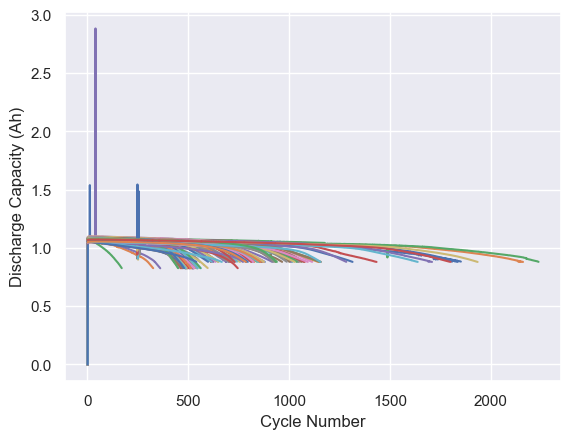

In [16]:
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

### Train and Test Split
If you are interested in using the same train/test split as the paper, use the indices specified below

In [14]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [15]:
test_ind

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

#### Exploring the dataset for battery B1C0



In [19]:
"""
batch entry structure (for refernce):

batch1['b1c0']
│
├── cycle_life: NumPy array
│       [1852.]
│
├── charge_policy: String
│       "3.6C(80%)-3.6C"
│
├── summary: Dictionary
│   ├── IR: NumPy array (Internal Resistance over cycles)
│   ├── QC: NumPy array (Charge Capacity over cycles)
│   ├── QD: NumPy array (Discharge Capacity over cycles)
│   ├── Tavg: NumPy array (Average Temperature over cycles)
│   ├── Tmin: NumPy array (Minimum Temperature over cycles)
│   ├── Tmax: NumPy array (Maximum Temperature over cycles)
│   ├── chargetime: NumPy array (Charging time over cycles)
│   └── cycle: NumPy array (Cycle numbers)
│
└── cycles: Dictionary (Detailed per-cycle data)
    ├── '0': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    ├── '1': Dictionary
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
    │
    └── ... : Additional cycles ('2', '3', ..., '1851')
    """


'\nbatch entry structure (for refernce):\n\nbatch1[\'b1c0\']\n│\n├── cycle_life: NumPy array\n│       [1852.]\n│\n├── charge_policy: String\n│       "3.6C(80%)-3.6C"\n│\n├── summary: Dictionary\n│   ├── IR: NumPy array (Internal Resistance over cycles)\n│   ├── QC: NumPy array (Charge Capacity over cycles)\n│   ├── QD: NumPy array (Discharge Capacity over cycles)\n│   ├── Tavg: NumPy array (Average Temperature over cycles)\n│   ├── Tmin: NumPy array (Minimum Temperature over cycles)\n│   ├── Tmax: NumPy array (Maximum Temperature over cycles)\n│   ├── chargetime: NumPy array (Charging time over cycles)\n│   └── cycle: NumPy array (Cycle numbers)\n│\n└── cycles: Dictionary (Detailed per-cycle data)\n    ├── \'0\': Dictionary\n    │   ├── I: NumPy array (Current data)\n    │   ├── Qc: NumPy array (Charge capacity data)\n    │   ├── Qd: NumPy array (Discharge capacity data)\n    │   ├── Qdlin: NumPy array (Linearized discharge capacity)\n    │   ├── T: NumPy array (Temperature data)\n    

In [16]:
batch1['b1c0'].keys()

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])

In [17]:
print(batch1['b1c0']['cycle_life'])
print(batch1['b1c0']['charge_policy'])
print(batch1['b1c0']['summary'].keys())
print(batch1['b1c0']['cycles'].keys())

print(len(batch1['b1c0']['summary']['IR']))
print(len(batch1['b1c0']['cycles'].keys()))

"""
For B1C0, all the 1851 cycles have a trends recorded for all the attributed (Ir, Qc, ..) and
Summary stores all the max values corresponding to those cycles (Just one max value for the 
entire trend)

"""

[[1852.]]
[[51]
 [54]
 [40]
 [48]
 [41]
 [51]
 [54]]
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '13

'\nFor B1C0, all the 1851 cycles have a trends recorded for all the attributed (Ir, Qc, ..) and\nSummary stores all the max values corresponding to those cycles (Just one max value for the \nentire trend)\n\n'

In [18]:
print(batch1['b1c0']['cycles']['1500'].keys())

print(batch1['b1c0']['summary']['QC'][1500])
print(batch1['b1c0']['cycles']['1500']['Qc'].max())
print(batch1.keys())

"""
See I told yaa !

"""

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])
0.97060257
0.97060257
dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])


'\nSee I told yaa !\n\n'

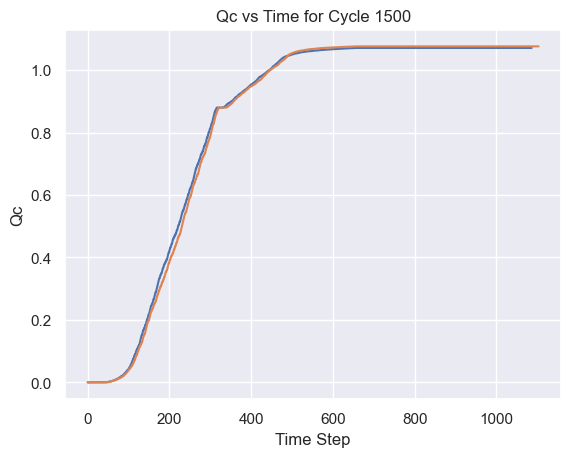

In [19]:
x = batch1['b1c0']['cycles']['1']['Qc']
plt.plot(np.arange(len(x)), x)
plt.xlabel('Time Step')
plt.ylabel('Qc')
plt.title('Qc vs Time for Cycle 1500')

x = batch1['b1c0']['cycles']['80']['Qc']
plt.plot(np.arange(len(x)), x)
plt.xlabel('Time Step')
plt.ylabel('Qc')
plt.title('Qc vs Time for Cycle 1500')

plt.show()

In [20]:
dQ = np.diff(batch1['b1c0']['cycles']['1500']['Qc'])
dV = np.diff(batch1['b1c0']['cycles']['1500']['V'])
dQ/dV

/var/folders/bt/_zgbcn7517lfmt__0z378d580000gn/T/ipykernel_67075/481082820.py:3: RuntimeWarning: invalid value encountered in divide
  dQ/dV


array([5.13117808e-05, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [21]:
"""
    │   ├── I: NumPy array (Current data)
    │   ├── Qc: NumPy array (Charge capacity data)
    │   ├── Qd: NumPy array (Discharge capacity data)
    │   ├── Qdlin: NumPy array (Linearized discharge capacity)
    │   ├── T: NumPy array (Temperature data)
    │   ├── Tdlin: NumPy array (Linearized temperature)
    │   ├── V: NumPy array (Voltage data)
    │   ├── dQdV: NumPy array (differential capacity vs. voltage)
    │   └── t: NumPy array (Time data)
"""

features = ["I", "Qc","Qd","T","V"]

features

['I', 'Qc', 'Qd', 'T', 'V']

In [54]:
FIRST_N_CYCLES = 100

In [263]:
batch1.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45'])

In [23]:
batch1["b1c45"]["cycles"]["100"]["dQdV"].shape

(1000,)

In [55]:
from collections import defaultdict
from scipy.interpolate import interp1d

def create_summary_df(batch, first_n_cycles):
    N = first_n_cycles
    CYCLE_THRESHOLD = 550

    def classify_battery(num_cycles: int):
        if num_cycles > CYCLE_THRESHOLD:
            return True
        return False

    df_dict = {
        "id": [],
        **{i:[] for i in features},
        "num_cycles": [],
    }

    for battery in batch.keys():
        df_dict["id"].append(battery)
        num_cycles = len(batch[battery]["summary"]["cycle"])
        df_dict["num_cycles"].append(num_cycles)
        for feature in features:
            print(f"feature={feature} for battery={battery}")
            aucs = np.zeros(N)
            for cycle in [str(i) for i in range(N)]:
                x = batch[battery]["cycles"][str(cycle)]["t"]
                y = batch[battery]["cycles"][str(cycle)][feature]
                auc = np.trapz(y, x)
                aucs[int(cycle)] = auc
            df_dict[feature].append(np.mean(aucs))


    df = pd.DataFrame(df_dict)
    # df["log_nc"] = np.log2(df["num_cycles"])
    df["high_lifetime"] = df["num_cycles"].apply(classify_battery)
    return df.drop(columns=["num_cycles"])

    
        

In [56]:
train_df = create_summary_df(batch1, FIRST_N_CYCLES)
train_df

feature=I for battery=b1c0
feature=Qc for battery=b1c0
feature=Qd for battery=b1c0
feature=T for battery=b1c0
feature=V for battery=b1c0
feature=I for battery=b1c1
feature=Qc for battery=b1c1
feature=Qd for battery=b1c1
feature=T for battery=b1c1
feature=V for battery=b1c1
feature=I for battery=b1c2
feature=Qc for battery=b1c2
feature=Qd for battery=b1c2
feature=T for battery=b1c2
feature=V for battery=b1c2
feature=I for battery=b1c3
feature=Qc for battery=b1c3
feature=Qd for battery=b1c3
feature=T for battery=b1c3
feature=V for battery=b1c3
feature=I for battery=b1c4
feature=Qc for battery=b1c4
feature=Qd for battery=b1c4
feature=T for battery=b1c4
feature=V for battery=b1c4
feature=I for battery=b1c5
feature=Qc for battery=b1c5
feature=Qd for battery=b1c5
feature=T for battery=b1c5
feature=V for battery=b1c5
feature=I for battery=b1c6
feature=Qc for battery=b1c6
feature=Qd for battery=b1c6
feature=T for battery=b1c6
feature=V for battery=b1c6
feature=I for battery=b1c7
feature=Qc for

,id,I,Qc,Qd,T,V,high_lifetime
0,b1c0,-0.822570,54.767643,14.323531,1866.595190,193.618092,True
1,b1c1,2.117211,52.747595,13.516413,1801.659461,187.710748,True
2,b1c2,2.123256,52.879439,13.535354,1809.848693,187.721561,True
3,b1c3,-9.309254,52.279939,17.098741,1693.518764,181.679194,True
4,b1c4,-9.211127,52.180374,17.044933,1770.127915,181.510227,True
5,b1c5,9.886996,49.187156,13.509768,1711.645857,179.176663,True
6,b1c6,3.994580,50.943067,13.512847,1750.816010,176.382897,True
7,b1c7,4.005836,51.403478,13.594648,1737.390656,176.434287,True
8,b1c9,0.043952,48.061223,13.534513,1677.789110,166.233258,True
9,b1c11,-1.107223,51.965970,17.658159,1831.658116,177.355854,True


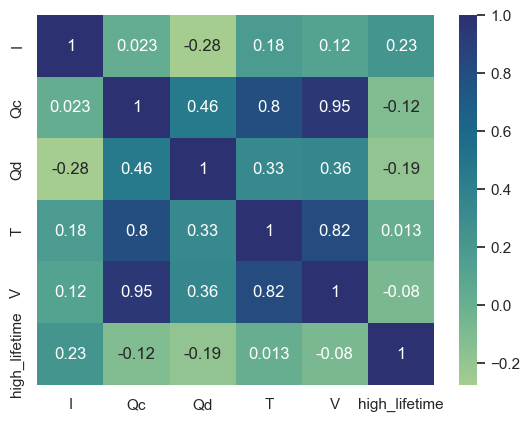

In [57]:
sns.heatmap(train_df.drop(columns=["id"]).corr(method="spearman"), annot=True, cmap='crest')
plt.show()

In [58]:
train_df

,id,I,Qc,Qd,T,V,high_lifetime
0,b1c0,-0.822570,54.767643,14.323531,1866.595190,193.618092,True
1,b1c1,2.117211,52.747595,13.516413,1801.659461,187.710748,True
2,b1c2,2.123256,52.879439,13.535354,1809.848693,187.721561,True
3,b1c3,-9.309254,52.279939,17.098741,1693.518764,181.679194,True
4,b1c4,-9.211127,52.180374,17.044933,1770.127915,181.510227,True
5,b1c5,9.886996,49.187156,13.509768,1711.645857,179.176663,True
6,b1c6,3.994580,50.943067,13.512847,1750.816010,176.382897,True
7,b1c7,4.005836,51.403478,13.594648,1737.390656,176.434287,True
8,b1c9,0.043952,48.061223,13.534513,1677.789110,166.233258,True
9,b1c11,-1.107223,51.965970,17.658159,1831.658116,177.355854,True


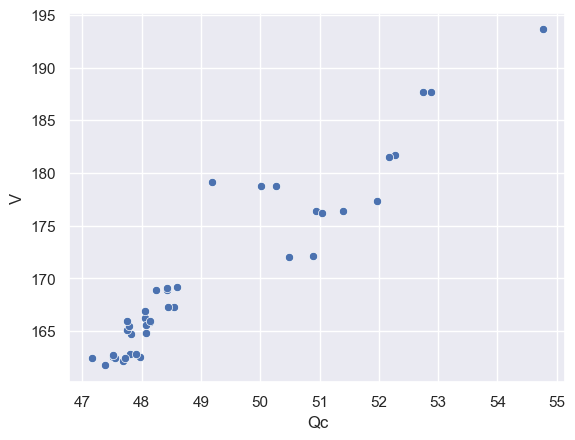

In [59]:
train_df_copy = train_df[train_df["id"] != "b1c18"].copy()
sns.scatterplot(train_df_copy, x="Qc", y="V")
plt.show()

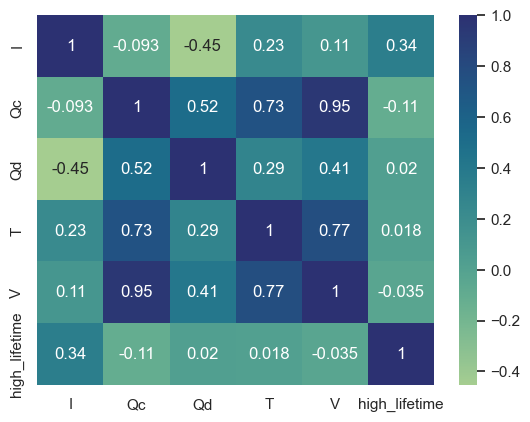

In [60]:
sns.heatmap(train_df_copy.drop(columns=["id"]).corr(method="pearson"), annot=True, cmap='crest')
plt.show()

In [61]:
rf_classifier = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    max_features="sqrt"
)

In [62]:
X_train = train_df_copy[[i for i in train_df_copy.columns if i not in ["high_lifetime", "id"]]]
Y_train = train_df_copy["high_lifetime"]

rf_classifier.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [63]:
y_hat = rf_classifier.predict(X_train)
f1_score(Y_train, y_hat)

1.0

In [64]:
primary_test_df = create_summary_df(batch2, FIRST_N_CYCLES)
X_primary_test = primary_test_df[[i for i in primary_test_df.columns if i not in ("high_lifetime", "id")]]
Y_primary_test = primary_test_df["high_lifetime"]

feature=I for battery=b2c0
feature=Qc for battery=b2c0
feature=Qd for battery=b2c0
feature=T for battery=b2c0
feature=V for battery=b2c0
feature=I for battery=b2c1
feature=Qc for battery=b2c1
feature=Qd for battery=b2c1
feature=T for battery=b2c1
feature=V for battery=b2c1
feature=I for battery=b2c2
feature=Qc for battery=b2c2
feature=Qd for battery=b2c2
feature=T for battery=b2c2
feature=V for battery=b2c2
feature=I for battery=b2c3
feature=Qc for battery=b2c3
feature=Qd for battery=b2c3
feature=T for battery=b2c3
feature=V for battery=b2c3
feature=I for battery=b2c4
feature=Qc for battery=b2c4
feature=Qd for battery=b2c4
feature=T for battery=b2c4
feature=V for battery=b2c4
feature=I for battery=b2c5
feature=Qc for battery=b2c5
feature=Qd for battery=b2c5
feature=T for battery=b2c5
feature=V for battery=b2c5
feature=I for battery=b2c6
feature=Qc for battery=b2c6
feature=Qd for battery=b2c6
feature=T for battery=b2c6
feature=V for battery=b2c6
feature=I for battery=b2c10
feature=Qc fo

In [65]:
y_hat = rf_classifier.predict(X_primary_test)
accuracy_score(Y_primary_test, y_hat) * 100

9.30232558139535

In [290]:
scaler = StandardScaler()

In [292]:
# Perform PCA
scaled_data = scaler.fit_transform(train_df[['I', 'Qc', 'Qd', 'T', 'V', 'log_nc']])
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])

pca_df

,PC1,PC2,PC3
0,-0.424723,-0.949059,2.034741
1,-0.470548,-0.454799,2.674666
2,-0.476627,-0.485724,2.772893
3,-0.386023,-2.549751,0.708557
4,-0.416131,-2.692105,1.204843
5,-0.357158,1.877208,1.285324
6,-0.248504,1.088085,-0.600859
7,-0.308761,0.798821,0.273972
8,-0.362838,-0.243158,0.520284
9,-0.270953,-0.221666,-0.371440


In [293]:
explained_variance.sum()

0.9999921649730155

In [294]:

X = pca_df[['PC1', 'PC2', 'PC3']] 
y = train_df['log_nc']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [295]:
# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 1.1310218107940093e-10
R-squared: 0.9999999994229103


In [296]:

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)  # You can adjust n_estimators for tuning

# Fit the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')


Random Forest Mean Squared Error: 0.006855426921067727
Random Forest R-squared: 0.9650210424892484


In [297]:
rf_model.fit(X, y)



RandomForestRegressor(n_estimators=1000, random_state=42)

In [298]:
batch2.keys()

dict_keys(['b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47'])

In [300]:
test_df1 = create_summary_df(batch2, 80)
test_df1

feature=I for battery=b2c0
feature=Qc for battery=b2c0
feature=Qd for battery=b2c0
feature=T for battery=b2c0
feature=V for battery=b2c0
feature=I for battery=b2c1
feature=Qc for battery=b2c1
feature=Qd for battery=b2c1
feature=T for battery=b2c1
feature=V for battery=b2c1
feature=I for battery=b2c2
feature=Qc for battery=b2c2
feature=Qd for battery=b2c2
feature=T for battery=b2c2
feature=V for battery=b2c2
feature=I for battery=b2c3
feature=Qc for battery=b2c3
feature=Qd for battery=b2c3
feature=T for battery=b2c3
feature=V for battery=b2c3
feature=I for battery=b2c4
feature=Qc for battery=b2c4
feature=Qd for battery=b2c4
feature=T for battery=b2c4
feature=V for battery=b2c4
feature=I for battery=b2c5
feature=Qc for battery=b2c5
feature=Qd for battery=b2c5
feature=T for battery=b2c5
feature=V for battery=b2c5
feature=I for battery=b2c6
feature=Qc for battery=b2c6
feature=Qd for battery=b2c6
feature=T for battery=b2c6
feature=V for battery=b2c6
feature=I for battery=b2c10
feature=Qc fo

,id,I,Qc,Qd,T,V,log_nc
0,b2c0,0.136908,55.005961,18.831373,1799.113430,188.710213,8.348728
1,b2c1,0.145166,53.166395,17.796110,1889.373705,186.792931,7.409391
2,b2c2,0.105721,55.998071,19.006592,1956.689023,188.685593,8.857981
3,b2c3,0.128342,55.168296,18.853252,1991.072511,188.406681,8.495855
4,b2c4,0.116678,55.598579,18.953316,1963.131055,188.997731,8.879583
5,b2c5,0.112552,55.901049,18.925482,1918.358750,188.893886,8.985842
6,b2c6,0.145363,54.659237,18.243901,1932.565971,187.721134,9.090112
7,b2c10,0.093518,55.472492,18.617249,1984.101978,188.170871,9.219169
8,b2c11,0.078115,55.535831,18.610574,1977.295893,188.258156,8.980140
9,b2c12,0.142522,55.211586,18.534178,1989.497309,188.129009,8.939579


In [229]:
test_df2 = create_summary_df(batch3, 80)
test_df2

,id,I,Qc,Qd,T,V,log_nc
0,b3c0,-0.239549,42.036149,11.942050,1476.202074,148.713866,9.977280
1,b3c1,-0.254133,41.393207,11.756447,1568.083342,146.586745,10.052568
2,b3c3,-0.256375,40.704992,11.611834,1604.233381,144.747954,10.121534
3,b3c4,-0.263498,42.967139,12.280202,1499.452348,151.118562,10.032046
4,b3c5,-0.277815,40.767108,11.916083,1596.334123,145.301104,9.691744
5,b3c6,-0.134079,39.651875,11.595463,1519.868347,144.246967,9.379378
6,b3c7,-0.351091,43.950703,12.635336,1587.765835,156.494214,10.841564
7,b3c8,-0.379251,43.407235,12.712819,1559.311636,152.338815,9.691744
8,b3c9,-0.407917,44.269906,12.801409,1579.811849,154.334658,10.019591
9,b3c10,-0.396997,42.857505,12.566972,1544.086224,153.280405,10.072803


In [302]:
scaled_data = scaler.transform(test_df1[['I', 'Qc', 'Qd', 'T', 'V', 'log_nc']])
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2', 'PC3'])

pca_df

,PC1,PC2,PC3
0,-1.213624,0.000138,-0.013199
1,-3.130033,0.000417,-0.000053
2,-0.174606,0.002251,0.001520
3,-0.913416,0.005723,0.005450
4,-0.130540,0.004489,0.001230
5,0.086241,0.002742,-0.003489
6,0.298949,0.009443,-0.005266
7,0.562289,0.002722,0.002416
8,0.074635,-0.001263,0.004098
9,-0.008149,0.010137,0.001745


In [304]:
explained_variance.sum()

0.9999863360838749

In [306]:
# Predict on the test set
y_pred_rf = rf_model.predict(pca_df[["PC1", "PC2", "PC3"]])

# Evaluate the model
mse_rf = mean_squared_error(test_df1["log_nc"], y_pred_rf)
r2_rf = r2_score(test_df1["log_nc"], y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

Random Forest Mean Squared Error: 0.639521373327083
Random Forest R-squared: -6.52374586712347


Random Forest Mean Squared Error: 0.746236438686239
Random Forest R-squared: -7.779211384685022


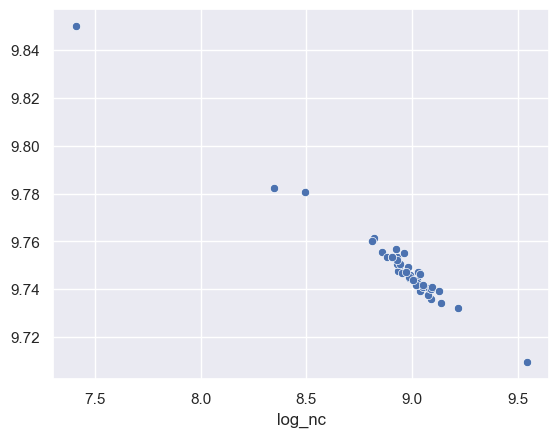

In [310]:
y_pred_rf = model.predict(pca_df[["PC1", "PC2", "PC3"]])

# Evaluate the model
mse_rf = mean_squared_error(test_df1["log_nc"], y_pred_rf)
r2_rf = r2_score(test_df1["log_nc"], y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')

sns.scatterplot(x=test_df1["log_nc"], y=y_pred_rf)
plt.show()

In [227]:
for i, batch in enumerate((batch1, batch2, batch3)):
    print(f"batch{i+1} = {len(batch)}")

batch1 = 41
batch2 = 43
batch3 = 40


In [70]:
X = df[["I","Qc","Qd","T","V"]]
Y = df[["num_cycles"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

In [75]:
X_train.values

array([[-4.51017926e-01,  5.17051410e+01,  1.39620881e+01,
         1.78730876e+03,  1.84331676e+02],
       [ 9.34334459e-02,  4.82407754e+01,  1.34802623e+01,
         1.73669547e+03,  1.66489888e+02],
       [ 3.32102738e-02,  4.81783986e+01,  1.34972086e+01,
         1.68522219e+03,  1.66759201e+02],
       [ 8.11204043e-02,  4.82346703e+01,  1.32986973e+01,
         1.73073021e+03,  1.69270805e+02],
       [ 6.09135419e+00,  4.91350204e+01,  1.35253712e+01,
         1.77059839e+03,  1.72350849e+02],
       [ 4.58648283e-02,  4.80509072e+01,  1.32216988e+01,
         1.68092193e+03,  1.65833780e+02],
       [ 6.53402530e-02,  4.79210651e+01,  1.35107130e+01,
         1.72696357e+03,  1.66616676e+02],
       [ 8.42503130e-02,  4.82668347e+01,  1.36218089e+01,
         1.70310488e+03,  1.65470066e+02],
       [ 5.92383425e-02,  4.77427894e+01,  1.32942667e+01,
         1.53203985e+03,  1.62579147e+02],
       [ 6.00653127e-02,  4.81061100e+01,  1.33955037e+01,
         1.66063081e+03

In [81]:
x_scaler = StandardScaler()
x_scaler.fit(X_train)

y_scaler = StandardScaler()
y_scaler.fit(y_train)

StandardScaler()

In [84]:
y_train_scaled = y_scaler.transform(y_train)
x_train_scaled = x_scaler.transform(X_train)

In [85]:
model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [87]:
y_test_scaled = y_scaler.transform(y_test)
x_test_scaled = x_scaler.transform(X_test)

In [89]:
y_hat = model.predict(x_test_scaled)

In [90]:
mean_squared_error(y_hat, y_test_scaled)

998.587455232923

In [92]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [93]:
regr.fit(x_train_scaled, y_train_scaled)

/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=2, random_state=0)

In [94]:

y_hat = regr.predict(x_test_scaled)
mean_squared_error(y_hat, y_test_scaled)

1.0214225060187003

In [95]:
y_hat

array([-0.16567819, -0.32302492, -0.48883885, -0.16016649,  2.61316505,
       -0.30924604, -0.25651243, -0.39588358, -0.35710414, -0.17357509,
       -0.3312714 , -0.24544987,  2.33017089, -0.19838739, -0.23843494,
        0.29711663,  0.17143639])

In [96]:
y_test_scaled

array([[-0.15200015],
       [-0.44306427],
       [-0.83114976],
       [ 0.13629193],
       [ 3.6595538 ],
       [-0.15754423],
       [-0.59275439],
       [-0.80897345],
       [-0.20744094],
       [-0.12982384],
       [-0.16586035],
       [-0.74521655],
       [-0.62601886],
       [-1.06122902],
       [-0.99192804],
       [ 1.43360629],
       [ 2.19591708]])

In [46]:
N = 100
MAX_CYCLE_LENGTH = 40_000
X = np.zeros((len(batch1), 5, N, MAX_CYCLE_LENGTH))
Y = np.zeros(len(batch1))

for b, battery in enumerate(batch1.keys()):
    num_cycles = len(batch1[battery]["summary"]["cycle"])
    Y[b] = num_cycles
    for n, feature in enumerate(features):
        for cycle in [str(i) for i in range(N)]:
            y = batch1[battery]["cycles"][str(cycle)][feature]
            X[b][n][int(cycle)][:len(y)] = y





In [238]:
X = pca_df
Y = df[["log_nc"]]

In [239]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# X_reshaped = X.reshape(41, 100, 5 * 40000)
# Y_reshaped = Y.reshape(-1,1)

# Define LSTM model
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=X.shape))  # Masking layer if you have padded values
model.add(LSTM(64, return_sequences=False))  # LSTM layer with 64 units
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Model summary
model.summary()

# Train the model
# Assuming a small number of epochs and batch size for testing; adjust as needed
model.fit(X, Y, epochs=10, batch_size=2)

/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 41, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 2), dtype=float32). Expected shape (None, 41, 2), but input has incompatible shape (None, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 2), dtype=float32)
  • training=True
  • mask=None

In [50]:
df.drop(columns=["id"]).corr()

,I,Qc,Qd,T,V,num_cycles
I,1.000000,-0.004653,-0.006339,-0.001225,-0.002933,-0.063459
Qc,-0.004653,1.000000,0.999981,0.999932,0.999955,-0.086313
Qd,-0.006339,0.999981,1.000000,0.999913,0.999891,-0.090521
T,-0.001225,0.999932,0.999913,1.000000,0.999887,-0.088829
V,-0.002933,0.999955,0.999891,0.999887,1.000000,-0.078543
num_cycles,-0.063459,-0.086313,-0.090521,-0.088829,-0.078543,1.000000


In [47]:
df.describe()

,I,Qc,Qd,T,V,num_cycles
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.187730,69.842811,30.754639,2302.275294,220.116911,920.341463
std,2.214011,135.963384,109.603000,3835.385354,330.988177,400.765867
min,-4.689709,47.319362,13.146395,1532.039849,162.392351,533.000000
25%,0.029184,47.995753,13.480262,1672.948515,165.203464,701.000000
50%,0.060065,48.266835,13.555017,1703.104875,166.759201,841.000000
75%,0.093938,49.081748,13.602017,1745.662599,170.155514,965.000000
max,6.091354,919.176589,715.431565,26259.701465,2287.513622,2236.000000


In [48]:
df.shape

(41, 7)

In [25]:

def plot_feature(feature, battery):
    cycle_start = 1000
    battery = battery or "b1c0"
    num_cycles = len(batch1[battery]["summary"]["cycle"])
    for cycle in ["1", "200",str(num_cycles-1)]:
        
        x = batch1[battery]["cycles"][str(cycle)]["t"]
        y = batch1[battery]["cycles"][str(cycle)][feature]
        # Calculate the area under the curve using the trapezoidal rule
        auc = np.trapz(y, x)
        mu = np.mean(y)
        sns.lineplot(x=x, y=y, label=f"cycle_{cycle}; AUC={auc:.2f}; mean={mu}")
    plt.title(f"{feature} for battery {battery}")
    plt.legend(loc="upper left")
    plt.show()




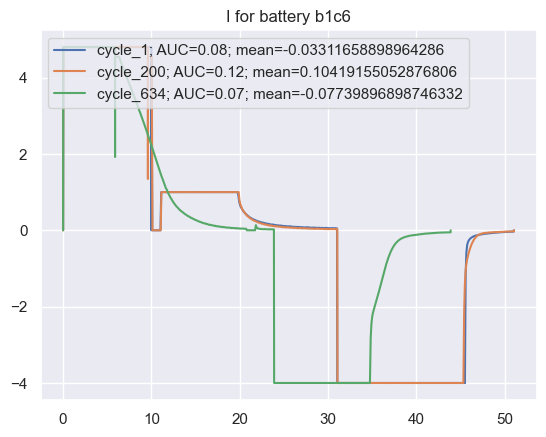

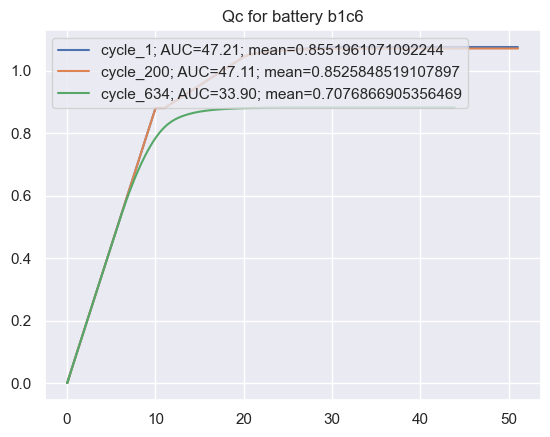

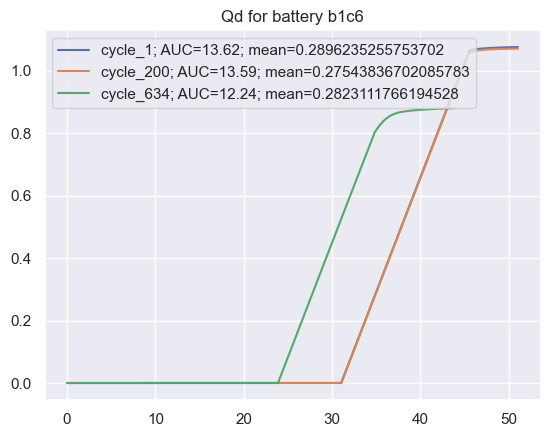

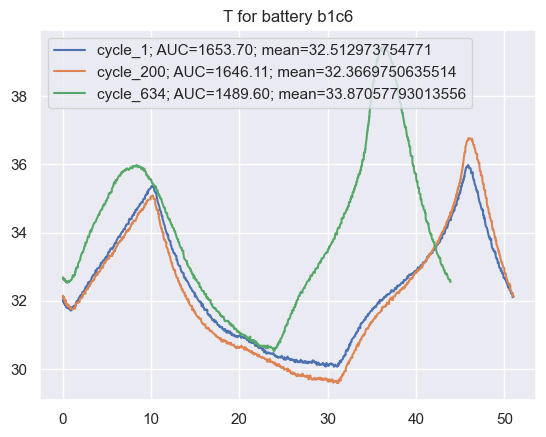

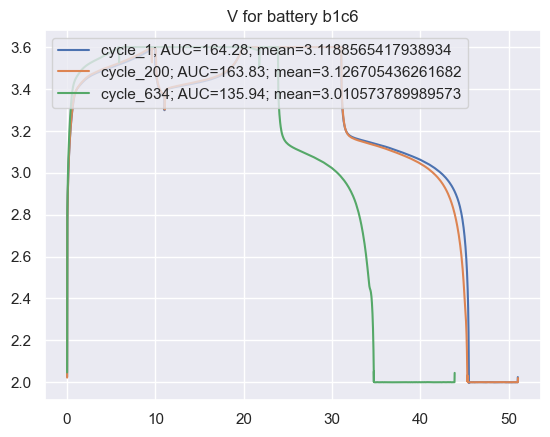

In [26]:
for feature in features:
    plot_feature(feature=feature, battery="b1c6")

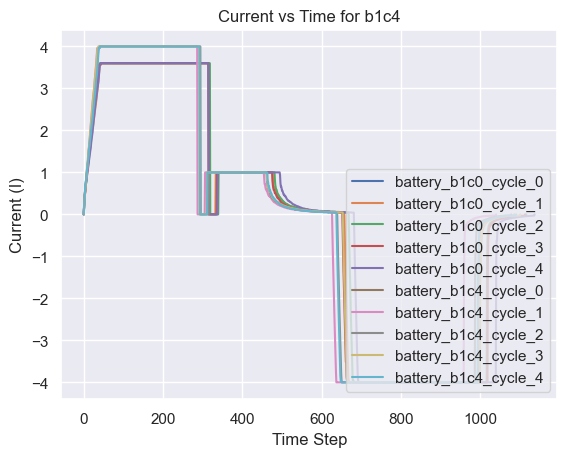

In [27]:


for battery in ["b1c0", "b1c4"]:
    cycles = 0
    for k, v in batch1[battery]["cycles"].items():

        if cycles == 5:
            break

        cycle = v["I"]
        plt.plot(np.arange(len(cycle)), cycle, label=f"battery_{battery}_cycle_{k}")
        plt.xlabel('Time Step')
        plt.ylabel('Current (I)')
        plt.title(f"Current vs Time for {battery}")

        cycles += 1

plt.legend(loc="lower right")
plt.show()





In [28]:
batch1["b1c0"]["cycle_life"]

array([[1852.]])

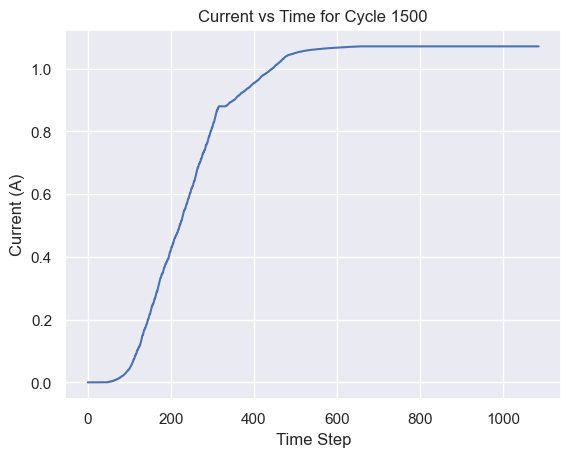

In [29]:
x = batch1['b1c0']['cycles']['1']['Qc']
plt.plot(np.arange(len(x)), x)
plt.xlabel('Time Step')
plt.ylabel('Current (A)')
plt.title('Current vs Time for Cycle 1500')
plt.show()

In [30]:
# For Battery b1c0
b1c0_summary_df = pd.DataFrame(batch1['b1c0']['summary'])
features = pd.DataFrame(batch1['b1c0']['summary']).iloc[:, 0:-1]
target = pd.DataFrame(batch1['b1c0']['summary']).iloc[:,-1]
features.head()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250
2,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777
3,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167
4,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442


<Figure size 1000x800 with 0 Axes>

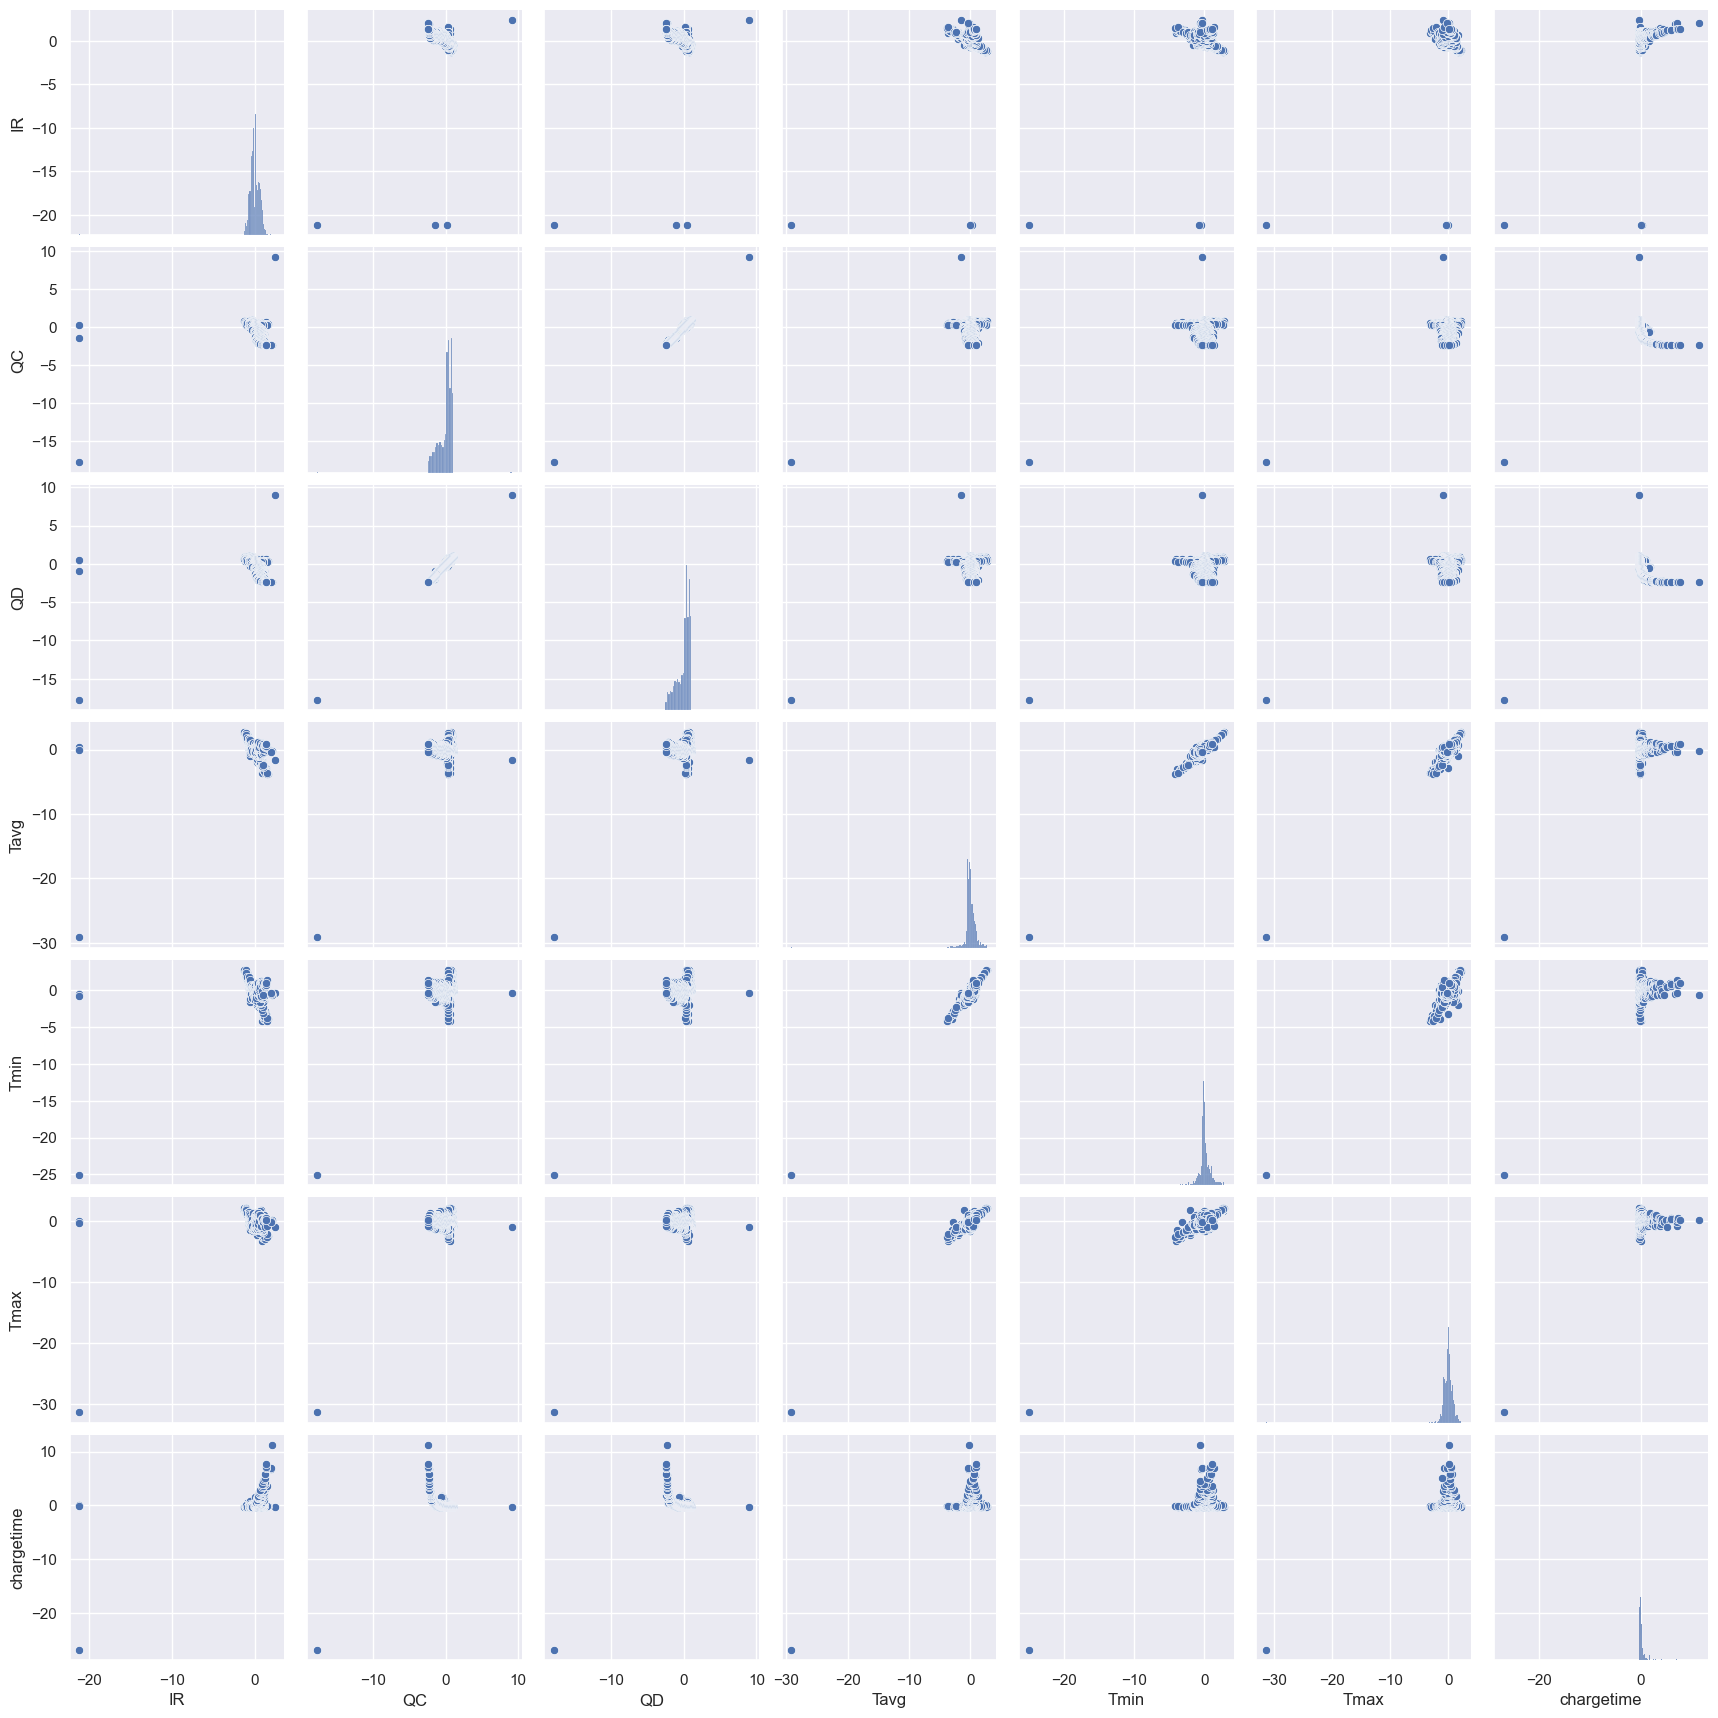

In [31]:
plt.figure(figsize=(10,8))

# Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Generate the pair plot (scatter plot matrix)
sns.pairplot(df_scaled)
plt.show()

### Random Forest implementation

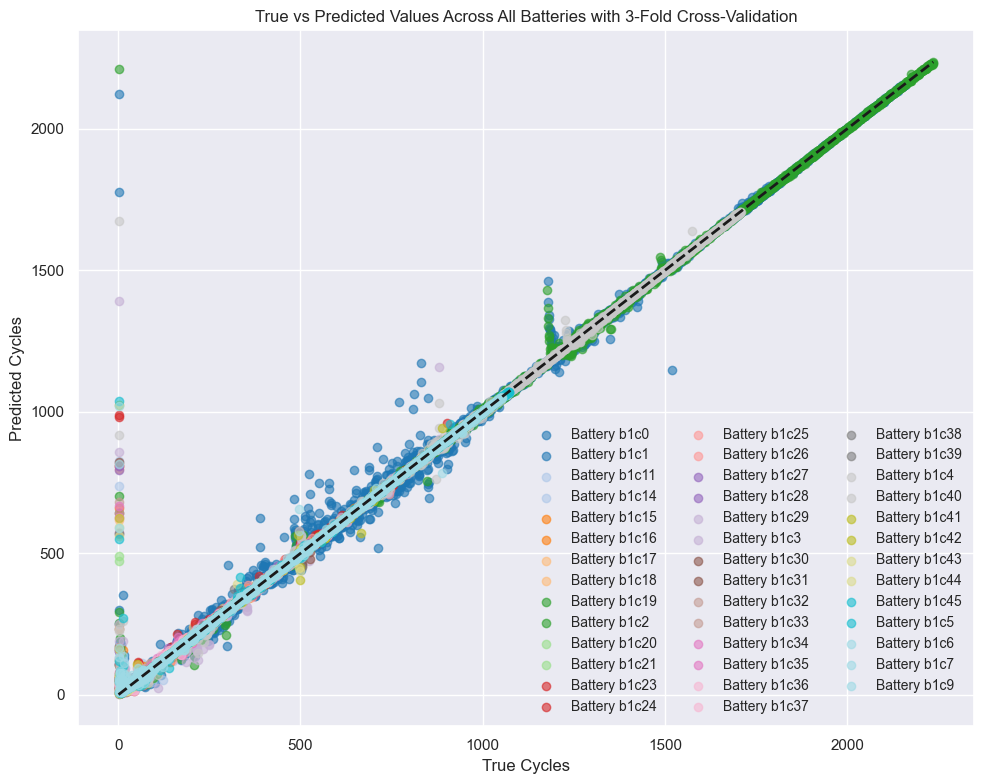

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize lists to store the metrics and predictions
mse_list = []
r2_list = []
battery_names = []

# Lists to store all true and predicted values across all batteries and folds
all_y_test = []
all_y_pred = []
all_battery_ids = []

# Number of folds for cross-validation
k = 3

# Iterate over each battery in batch1
for battery_key in batch1.keys():
    battery_summary_df = pd.DataFrame(batch1[battery_key]['summary'])
    features = battery_summary_df.iloc[:, :-1]
    target = battery_summary_df.iloc[:, -1]

    # Check if there is enough data to perform K-fold cross-validation
    if len(features) < k:
        print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
        continue

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Lists to store metrics for each fold
    fold_mse = []
    fold_r2 = []

    # Lists to store true and predicted values for each fold
    battery_y_test = []
    battery_y_pred = []

    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_regressor.fit(X_train, y_train)
        y_pred = rf_regressor.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store metrics for this fold
        fold_mse.append(mse)
        fold_r2.append(r2)

        # Store true and predicted values
        battery_y_test.extend(y_test)
        battery_y_pred.extend(y_pred)

    # Compute average metrics across folds for this battery
    avg_mse = np.mean(fold_mse)
    avg_r2 = np.mean(fold_r2)

    # Store the average metrics
    mse_list.append(avg_mse)
    r2_list.append(avg_r2)
    battery_names.append(battery_key)

    # Store the true and predicted values along with battery ID
    all_y_test.extend(battery_y_test)
    all_y_pred.extend(battery_y_pred)
    all_battery_ids.extend([battery_key] * len(battery_y_test))

# Convert lists to numpy arrays for plotting
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_battery_ids = np.array(all_battery_ids)

# Create a color map for batteries
unique_batteries = np.unique(all_battery_ids)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
color_map = dict(zip(unique_batteries, colors))

# Plotting
plt.figure(figsize=(10, 8))
for battery in unique_batteries:
    idx = all_battery_ids == battery
    plt.scatter(
        all_y_test[idx],
        all_y_pred[idx],
        alpha=0.6,
        label=f'Battery {battery}',
        color=color_map[battery]
    )

# Plot the ideal line
min_val = min(all_y_test.min(), all_y_pred.min())
max_val = max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.xlabel('True Cycles')
plt.ylabel('Predicted Cycles')
plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation')

# Adjust the legend
plt.legend(
    fontsize='smaller',
    loc='lower right',
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


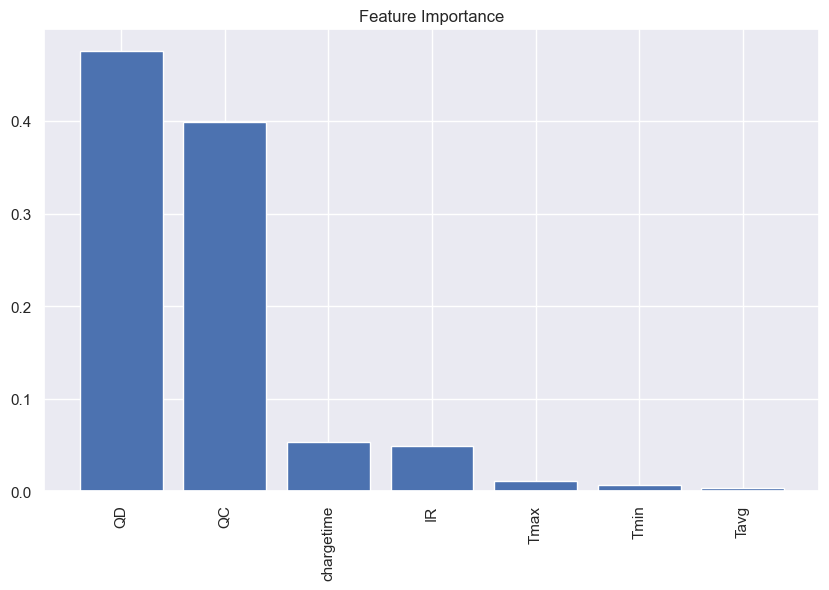

In [33]:
importances = rf_regressor.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), features.columns[indices], rotation=90)
plt.show()


In [34]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_regressor, features, target, cv=5, scoring='r2')

# Print the cross-validation R-squared scores
print("Cross-Validation R-squared Scores:", cv_scores)
print("Mean R-squared Score:", np.mean(cv_scores))


Cross-Validation R-squared Scores: [ -5.29730607   0.60131287  -0.30100859  -0.04938771 -14.72343784]
Mean R-squared Score: -3.9539654670851667


### LSTM implementation

In [35]:
# # Initialize lists to store the metrics and predictions
# mse_list = []
# r2_list = []
# battery_names = []

# # Lists to store all true and predicted values across all batteries and folds
# all_y_test = []
# all_y_pred = []
# all_battery_ids = []

# # Number of folds for cross-validation
# k = 3

# # Iterate over each battery in batch1
# for battery_key in batch1.keys():
#     battery_summary_df = pd.DataFrame(batch1[battery_key]['summary'])

#     # Assuming 'time' is a column representing the sequence order
#     # and that the data is sorted by 'time'
#     # If not, sort the data
#     # battery_summary_df = battery_summary_df.sort_values('time')

#     features = battery_summary_df.iloc[:, :-1].values  # Convert to NumPy array
#     target = battery_summary_df.iloc[:, -1].values     # Convert to NumPy array

#     # Check if there is enough data to perform K-fold cross-validation
#     if len(features) < k:
#         print(f"Not enough data for battery {battery_key} to perform {k}-fold cross-validation. Skipping...")
#         continue

#     # Reshape features for LSTM: (samples, timesteps, features)
#     # Here, we'll assume timesteps = 1 (since we have tabular data)
#     # If you have sequences, adjust timesteps accordingly
#     features = features.reshape((features.shape[0], 1, features.shape[1]))

#     # Initialize KFold
#     kf = KFold(n_splits=k, shuffle=True, random_state=42)

#     # Lists to store metrics for each fold
#     fold_mse = []
#     fold_r2 = []

#     # Lists to store true and predicted values for each fold
#     battery_y_test = []
#     battery_y_pred = []

#     # Perform K-fold cross-validation
#     fold = 1
#     for train_index, test_index in kf.split(features):
#         print(f"Battery {battery_key}, Fold {fold}")

#         X_train, X_test = features[train_index], features[test_index]
#         y_train, y_test = target[train_index], target[test_index]

#         # Define the LSTM model
#         model = Sequential()
#         model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
#         model.add(Dense(1))  # Output layer for regression
#         model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#         # Train the model
#         history = model.fit(
#             X_train, y_train,
#             epochs=50,
#             batch_size=16,
#             validation_data=(X_test, y_test),
#             verbose=0  # Set to 1 to see training progress
#         )

#         # Predict on the test set
#         y_pred = model.predict(X_test).flatten()

#         mse = mean_squared_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)

#         # Store metrics for this fold
#         fold_mse.append(mse)
#         fold_r2.append(r2)

#         # Store true and predicted values
#         battery_y_test.extend(y_test)
#         battery_y_pred.extend(y_pred)

#         fold += 1

#     # Compute average metrics across folds for this battery
#     avg_mse = np.mean(fold_mse)
#     avg_r2 = np.mean(fold_r2)

#     # Store the average metrics
#     mse_list.append(avg_mse)
#     r2_list.append(avg_r2)
#     battery_names.append(battery_key)

#     # Store the true and predicted values along with battery ID
#     all_y_test.extend(battery_y_test)
#     all_y_pred.extend(battery_y_pred)
#     all_battery_ids.extend([battery_key] * len(battery_y_test))

# # Convert lists to numpy arrays for plotting
# all_y_test = np.array(all_y_test)
# all_y_pred = np.array(all_y_pred)
# all_battery_ids = np.array(all_battery_ids)

# # Create a color map for batteries
# unique_batteries = np.unique(all_battery_ids)
# colors = plt.cm.tab20(np.linspace(0, 1, len(unique_batteries)))
# color_map = dict(zip(unique_batteries, colors))

# # Plotting
# plt.figure(figsize=(10, 8))
# for battery in unique_batteries:
#     idx = all_battery_ids == battery
#     plt.scatter(
#         all_y_test[idx],
#         all_y_pred[idx],
#         alpha=0.6,
#         label=f'Battery {battery}',
#         color=color_map[battery]
#     )

# # Plot the ideal line
# min_val = min(all_y_test.min(), all_y_pred.min())
# max_val = max(all_y_test.max(), all_y_pred.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# plt.xlabel('True Cycles')
# plt.ylabel('Predicted Cycles')
# plt.title('True vs Predicted Values Across All Batteries with 3-Fold Cross-Validation (LSTM)')

# # Adjust the legend
# plt.legend(
#     fontsize='smaller',
#     loc='lower right',
#     ncol=3,
#     frameon=False
# )

# plt.tight_layout()
# plt.show()


Battery b1c0, Fold 1


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c0, Fold 2


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c0, Fold 3


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c1, Fold 1


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c1, Fold 2


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c1, Fold 3


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c2, Fold 1


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c2, Fold 2


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Battery b1c2, Fold 3


/Users/prithaj/.local/share/virtualenvs/dd_battery_mdl-L1HeCxWz/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 